# Analysis

## Load data

In [118]:
import pandas as pd
df = pd.read_csv("../data/full.csv")

In [119]:
print(df.columns)

Index(['Unnamed: 0', 'Unnamed: 0_x', 'date', 'country', 'id', 'start', 'end',
       'severity', 'status', 'location', 'service_name',
       'number_affected_products', 'city', 'Unnamed: 0_y', 'Start Date',
       'End Date', 'Geo Locations', 'Disaster Type', 'Total Damages',
       'Total Deaths', 'Total Affected'],
      dtype='object')


## Cleaning

Remove rows that are not interesting to us

In [120]:
# remove USA because it is to big
df = df.drop(df[df["country"] == "USA"].index)
# remove lines without infromation
old_size = df.size
df = df.dropna(subset=["id", "Disaster Type"], how="all")
print(f"Removed {old_size - df.size}/{old_size} where outage and weather event were NaN.")

Removed 92085/204834 where outage and weather event were NaN.


Convert dates that represent string to actual dates

In [121]:
# longest disaster duration
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["End Date"] = pd.to_datetime(df["End Date"], errors="coerce")
df["start"] = pd.to_datetime(df["start"], errors="coerce")
df["end"] = pd.to_datetime(df["end"], errors="coerce")

Add information about the duration of outages and weather events

In [122]:
df["outage_duration_secs"] = (df["end"] - df["start"]).dt.seconds
df["weather_duration_days"] = (df["End Date"] - df["Start Date"]).dt.days
# because wather events that were on one day only shouldn't be zero we add one day to all
df["weather_duration_days"] += 1

Remove incidents that are just too long to have any meaningful correlation

In [123]:
# weather events that took longer than 2 weeks
df = df.drop(df[df["weather_duration_days"] > 14].index)

## Encoding

### Dependent Variable

Create a continous variable representing outage severity on a scale from 0 to 1.

We have three factors influencing our final score:
- severity
- outage duraction
- number of affected services

In [124]:
WEIGHTS = {
    "severity": 0.5,
    "duration": 0.4,
    "numAffProd": 0.1,
    "damages": 0.5,
    "deaths": 0.4,
    "affected": 0.1,
}

First we need to nomarlize the inputs

In [125]:
# min-max normalization

# since severity is not continous we can normalize with the encoding
df.loc[df["severity"]== "low", "norm_severity"] = 0
df.loc[df["severity"] == "medium", "norm_severity"] = 0.5
df.loc[df["severity"] == "high", "norm_severity"] = 1

# min-max normalisation for continous values
df["norm_duration"] = (df["outage_duration_secs"] - df["outage_duration_secs"].min()) / (df["outage_duration_secs"].max() - df["outage_duration_secs"].min())
df["norm_num_aff_prod"] = (df["number_affected_products"] - df["number_affected_products"].min()) / (df["number_affected_products"].max() - df["number_affected_products"].min())

In [126]:
# z-score normalisation

# since severity is not continous we can normalize with the encoding
df.loc[df["severity"]== "low", "enc_severity"] = 0
df.loc[df["severity"] == "medium", "enc_severity"] = 1
df.loc[df["severity"] == "high", "enc_severity"] = 2


# normalisation by z-score method
df["z_norm_severity"] = (df["enc_severity"] - df["enc_severity"].mean()) / df["enc_severity"].std()
df["z_norm_duration"] = (df["outage_duration_secs"] - df["outage_duration_secs"].mean()) / df["outage_duration_secs"].std()
df["z_norm_num_aff_prod"] = (df["number_affected_products"] - df["number_affected_products"].mean()) / df["number_affected_products"].std()

Create final score by multiplying normalized values with their weights and pumping them through the logistic function.

In [127]:
df["cont_dependent"] = (df["norm_severity"] * WEIGHTS["severity"] + \
                       df["norm_duration"] * WEIGHTS["duration"] + \
                       df["norm_num_aff_prod"] * WEIGHTS["numAffProd"])

df["z_cont_dependent"] = (df["z_norm_severity"] * WEIGHTS["severity"] + \
                       df["z_norm_duration"] * WEIGHTS["duration"] + \
                       df["z_norm_num_aff_prod"] * WEIGHTS["numAffProd"])
# min-max normalized values need to be scaled onto a 0 to 1 scale
df["cont_dependent"] = (df["cont_dependent"] - df["cont_dependent"].min()) / (df["cont_dependent"].max() - df["cont_dependent"].min())

# replace NaN with simply 0
df["cont_dependent"] = df["cont_dependent"].fillna(0)
df["z_cont_dependent"] = df["z_cont_dependent"].fillna(0)

[]

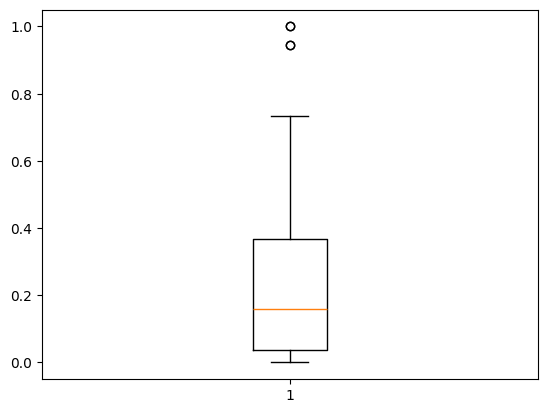

In [128]:
# Print dependent variable
import numpy as np
import matplotlib.pyplot as plt

# plot the data
plt.boxplot(df["cont_dependent"])

plt.plot()

### Independent variable

In [129]:
# Normalise the desired variables
df["norm_damages"] = (df["Total Damages"] - df["Total Damages"].min()) / (df["Total Damages"].max() - df["Total Damages"].min())
df["norm_deaths"] = (df["Total Deaths"] - df["Total Deaths"].min()) / (df["Total Deaths"].max() - df["Total Deaths"].min())
df["norm_affected"] = (df["Total Affected"] - df["Total Affected"].min()) / (df["Total Affected"].max() - df["Total Affected"].min())

# normalisation by z-score method
df["z_norm_damages"] = (df["Total Damages"] - df["Total Damages"].mean()) / df["Total Damages"].std()
df["z_norm_deaths"] = (df["Total Deaths"] - df["Total Deaths"].mean()) / df["Total Deaths"].std()
df["z_norm_affected"] = (df["Total Affected"] - df["Total Affected"].mean()) / df["Total Affected"].std()

In [130]:
# replace NaN with 0
df["norm_damages"] = df["norm_damages"].fillna(0)
df["norm_deaths"] = df["norm_deaths"].fillna(0)
df["norm_affected"] = df["norm_affected"].fillna(0)
df["z_norm_damages"] = df["z_norm_damages"].fillna(0)
df["z_norm_deaths"] = df["z_norm_deaths"].fillna(0)
df["z_norm_affected"] = df["z_norm_affected"].fillna(0)

# compute weighted score
df["cont_independent"] = (df["norm_damages"] * WEIGHTS["damages"] + \
                       df["norm_deaths"] * WEIGHTS["deaths"] + \
                       df["norm_affected"] * WEIGHTS["affected"])

df["z_cont_independent"] = (df["z_norm_damages"] * WEIGHTS["damages"] + \
                       df["z_norm_deaths"] * WEIGHTS["deaths"] + \
                       df["z_norm_affected"] * WEIGHTS["affected"])


[]

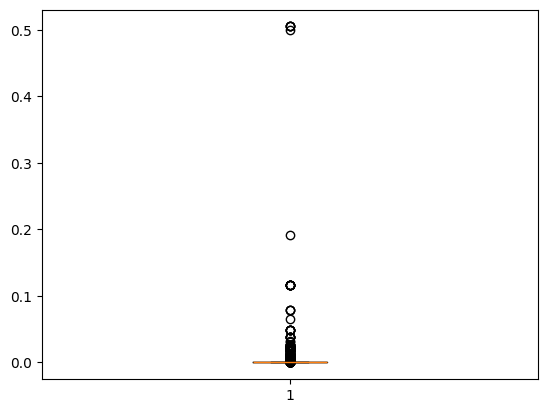

In [131]:
# Print independent variable
import numpy as np
import matplotlib.pyplot as plt

# plot the data
plt.boxplot(df[["cont_independent"]])
# plt.scatter(df["cont_independent"], df["cont_independent"])

plt.plot()

## Linear regression

In [132]:
# failed experiment
# df_final = df[df[["cont_independent"]] > 0.1]
# df_final["cont_dependent"] = df_final["cont_dependent"].fillna(0)
# df_final = df_final.dropna(subset=["cont_independent"])
# print(df_final.size)
# print(df_final)

Coefficients: 
 [-0.08507946]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2843
Date:                Sat, 07 Oct 2023   Prob (F-statistic):              0.594
Time:                        11:37:12   Log-Likelihood:                 1116.3
No. Observations:                5186   AIC:                            -2229.
Df Residuals:                    5184   BIC:                            -2215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2194      0.003     80.766      0.0

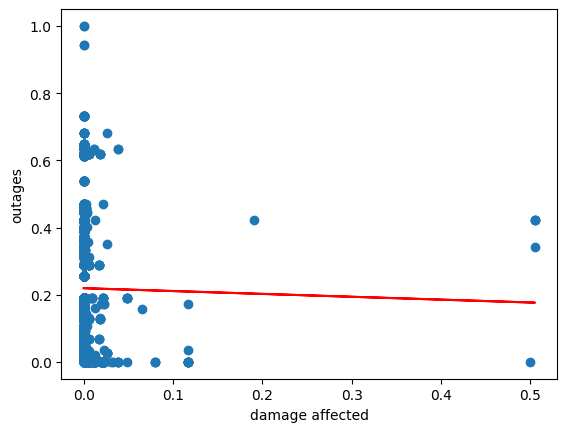

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

# plot the data
plt.scatter(df["cont_independent"], df["cont_dependent"], )
plt.xlabel("damage affected")
plt.ylabel("outages")
# plt.savefig("outages_weather_scatter.png")


# model using linear regression
X = df["cont_independent"].to_numpy().reshape(-1, 1)
Y = df["cont_dependent"].to_numpy()
reg = linear_model.LinearRegression()
reg.fit(X, Y)
print("Coefficients: \n", reg.coef_)

predicted_Y = reg.predict(X)

plt.plot(X, predicted_Y, color="red")


X = sm.add_constant(X) # add const to allow for constant offset of gradient
stats_results = sm.OLS(Y, X).fit()
print(stats_results.summary())

Coefficients: 
 [[-0.67282631]]
Optimization terminated successfully.
         Current function value: 0.612299
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5186
Model:                          Logit   Df Residuals:                     5184
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Oct 2023   Pseudo R-squ.:               0.0003641
Time:                        12:22:26   Log-Likelihood:                -3175.4
converged:                       True   LL-Null:                       -3176.5
Covariance Type:            nonrobust   LLR p-value:                    0.1283
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8413      0.030     27.732      0.000       0.782       0.9

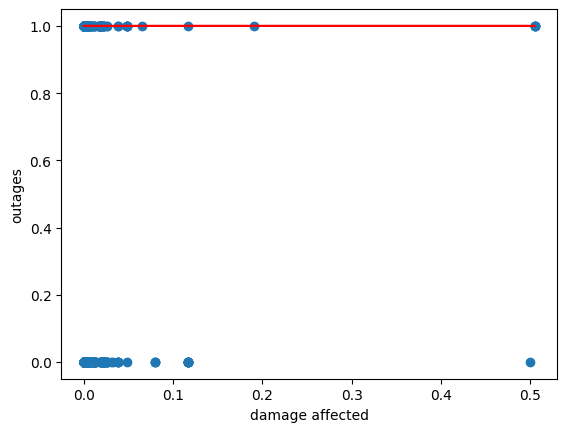

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

df.loc[df['cont_dependent'] <= 0.05, 'binary_dependent'] = 0
df.loc[df['cont_dependent'] > 0.05, 'binary_dependent'] = 1

# plot the data
plt.scatter(df["cont_independent"], df["binary_dependent"], )
plt.xlabel("damage affected")
plt.ylabel("outages")
# plt.savefig("outages_weather_scatter.png")


# model using linear regression
X = df["cont_independent"].to_numpy().reshape(-1, 1)
Y = df["binary_dependent"].to_numpy()
reg = linear_model.LogisticRegression()
reg.fit(X, Y)
print("Coefficients: \n", reg.coef_)

predicted_Y = reg.predict(X)

plt.plot(X, predicted_Y, color="red")


X = sm.add_constant(X) # add const to allow for constant offset of gradient
stats_results = sm.Logit(Y, X).fit()
print(stats_results.summary())